In [1]:
import os
import sys

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

In [92]:
from collections import defaultdict
from flow_wmd.documents import Document
from flow_wmd.gale_shapeley import Matcher
from flow_wmd.models import LC_RWMD, WMD, WMDManyToMany, WMDPairs
from flow_wmd.utils import *

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from random import shuffle
from scipy.spatial.distance import is_valid_dm, cdist
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import cluster

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import umap
import umap.plot

%load_ext autoreload
%autoreload 2

random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Prepare IMDB data

### 1.1 Load data and stopwords.

In [3]:
%%time

PATH = "../data/yelp_dataset/"
yelp_data = []
r_dtypes = {"review_id":str,
            "user_id":str,
            "business_id":str,
            "stars": np.int32, 
            "date":str,
            "text":str,
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32}
drop = ['review_id', 'user_id', 'useful', 'funny', 'cool']
query = "date >= '2017-12-01' and (stars==1 or stars ==5)"

with open(f"{PATH}yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, dtype=r_dtypes, chunksize=1000)
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=drop).query(query)
        yelp_data.append(reduced_chunk)
    
yelp_data = pd.concat(yelp_data, ignore_index=True)


CPU times: user 2min 54s, sys: 10.5 s, total: 3min 5s
Wall time: 3min 9s


In [4]:
yelp_data.shape

(1948607, 4)

In [5]:
yelp_business = pd.read_json(f"{PATH}yelp_academic_dataset_business.json", orient="records", lines=True)
yelp_business.shape

(160585, 14)

In [6]:
yelp_business = yelp_business[yelp_business.city.isin(["Portland", "Atlanta"])]
yelp_business.shape

(30815, 14)

In [7]:
yelp_merged = yelp_data.merge(yelp_business, on='business_id')

In [8]:
yelp_merged.shape

(451826, 17)

In [9]:
yelp_merged = yelp_merged.rename(columns={"stars_x":"stars"})

In [325]:
categories = [c.split(",") for c in yelp_merged.categories if c is not None]

In [311]:
c_count = Counter(c.strip() for c_list in categories for c in set(c_list))
c_count.most_common()[:30]

[('Restaurants', 272644),
 ('Food', 125420),
 ('Nightlife', 97019),
 ('Bars', 92658),
 ('Breakfast & Brunch', 55588),
 ('American (New)', 51193),
 ('American (Traditional)', 45802),
 ('Shopping', 40107),
 ('Coffee & Tea', 35901),
 ('Event Planning & Services', 35797),
 ('Sandwiches', 35124),
 ('Beauty & Spas', 34342),
 ('Home Services', 27398),
 ('Cocktail Bars', 27397),
 ('Southern', 25006),
 ('Seafood', 22942),
 ('Health & Medical', 21841),
 ('Mexican', 21828),
 ('Burgers', 21287),
 ('Pizza', 19637),
 ('Desserts', 19446),
 ('Bakeries', 18827),
 ('Local Services', 18501),
 ('Vegan', 17800),
 ('Vegetarian', 17096),
 ('Hotels & Travel', 16855),
 ('Automotive', 16844),
 ('Asian Fusion', 16781),
 ('Salad', 16769),
 ('Beer', 16370)]

In [317]:
yelp_categorized = yelp_merged.assign(categories=yelp_merged['categories'].str.split(',')).explode('categories')
yelp_categorized.categories = yelp_categorized.categories.str.strip()
yelp_categorized.shape

In [320]:
yelp_filtered = yelp_categorized[yelp_categorized.categories.isin(['Restaurants','Health & Medical'])]
yelp_filtered.shape

In [343]:
s_size = 1000
rs = 42
sample = yelp_filtered.groupby(["stars", "categories"]).sample(n=s_size, random_state=rs).reset_index()
sample.shape

(4000, 18)

In [344]:
stopword_list=stopwords.words('english')

### 1.2 Remove special formatting and stopwords

In [345]:
tokenizer = ToktokTokenizer()

Remove stopwords before denoising, lemmatizing and removing special characters.

In [346]:
%%time 

sample['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['text']]

CPU times: user 1.53 s, sys: 127 ms, total: 1.65 s
Wall time: 1.93 s


Denoise, remove special characters, lemmatize.

In [347]:
%%time

sample['review_clean']=sample['review_clean'].apply(denoise_text)
sample['review_clean']=sample['review_clean'].apply(remove_special_characters)
sample['review_clean']=sample['review_clean'].apply(simple_lemmatizer)

CPU times: user 1.36 s, sys: 122 ms, total: 1.48 s
Wall time: 1.69 s


Remove stopwords again, after other preprocessing.

In [348]:
%%time 

sample['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['review_clean']]

CPU times: user 826 ms, sys: 14.7 ms, total: 841 ms
Wall time: 862 ms


Find phrases.

In [349]:
PHRASING = True
MIN = 500
THRESHOLD = 200

In [350]:
%%time

if PHRASING:
    sample['review_clean']= get_phrases([tokenizer.tokenize(i) for i in sample['review_clean']],
                                        min_count = MIN, 
                                        threshold = THRESHOLD,
                                        save=False,
                                        load=True,
                                        PATH="../embeddings/")

Finding bigrams in data.
Finding trigrams in data.
CPU times: user 17.6 s, sys: 3.77 s, total: 21.4 s
Wall time: 22.9 s


Data _before_ preprocessing and phrasing.

In [351]:
sample['text'][6]

"Very poor business practices and patient relations. Some doctors and offices treat you like a human and make you feel good about being a patient. This is not one of them. If you want a relationship with your doctor, a good experience, returned phone calls and professionalism, don't go here. Looks like I'm another reviewer heading to the GA Board of Dentistry......"

Data _after_ preprocessing and phrasing.

In [352]:
#sample['review_clean'][0]
" ".join(sample['review_clean'][6])

'poor business_practice patient relation doctor_office treat like human make feel good patient one want relationship doctor good experience returned phone_call professionalism go look like another_reviewer heading ga board_dentistry'

In [353]:
sample["sentiment"] = ['positive' if s == 5 else 'negative' for s in sample['stars']]

In [354]:
sample[["sentiment", "stars"]]

,sentiment,stars
0,negative,1
1,negative,1
2,negative,1
3,negative,1
4,negative,1
...,...,...
3995,positive,5
3996,positive,5
3997,positive,5
3998,positive,5


In [355]:
sample.head()

,index,business_id,stars,text,date,name,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,review_clean,sentiment
0,127548,yfYIxgJcjamxnztuDhitUg,1,"this place is a disaster, and I hate My doctor...",2019-04-25 14:34:31,Atlanta Center for Reproductive Medicine,"5909 Peachtree Dunwoody Rd, Ste 600",Atlanta,GA,30328,33.917085,-84.349500,2.5,86,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",Health & Medical,"{'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...","[place, disaster, hate, doctor, carpenter, nur...",negative
1,77717,Mpzv9m1f9qzl5UUHZyTemw,1,I've come here many times. It's hit or miss. T...,2019-12-02 03:38:21,Fly Dragon Spa,1928 NE 42nd Ave,Portland,OR,97213,45.536932,-122.619541,3.5,118,1,"{'BusinessParking': '{'garage': False, 'street...",Health & Medical,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...","[come, many, time, hit_miss, evening, male_mas...",negative
2,289181,Hb9O0Ox97v1uxCt77sLoMQ,1,DO NOT GO HERE UNLESS YOU WANT TO BE RIPPED OF...,2018-03-07 22:43:01,Zama Massage,2149 NE Broadway St,Portland,OR,97232,45.535209,-122.643698,4.5,468,1,"{'ByAppointmentOnly': 'False', 'BikeParking': ...",Health & Medical,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...","[go, unless, want, ripped, lied, immensely, di...",negative
3,127843,vOj3VF7l-aUPSHBmasgHPQ,1,uh. this place is definitely closed. boarded u...,2020-01-06 15:15:40,"Joseph Allen, DDS - JBM Dent",1336 Glenwood Ave SE,Atlanta,GA,30316,33.740468,-84.343748,4.5,6,0,{'ByAppointmentOnly': 'False'},Health & Medical,"{'Monday': '8:30-16:30', 'Tuesday': '8:30-16:3...","[uh, place, definitely, closed, boarded, windo...",negative
4,358414,2cqd12IDUfOwIBMXDxyy8Q,1,I had a first time appointment yesterday and u...,2019-01-17 03:26:01,Executive Park Dentistry,"17 Executive Park Dr NE, Ste 100",Atlanta,GA,30329,33.827726,-84.339213,4.5,44,1,"{'ByAppointmentOnly': 'True', 'WiFi': 'u'free'...",Health & Medical,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '...","[first, time, appointment, yesterday, ultimate...",negative


In [356]:
sample = sample.sort_values("sentiment").reset_index()

In [357]:
sample.categories[1].split(" ")

['Restaurants']

### 1.3 Separate pos and neg reviews

In [358]:
pos = sample[sample.sentiment == "positive"].reset_index(drop=True)
neg = sample[sample.sentiment == "negative"].reset_index(drop=True)

In [359]:
pos = pos.review_clean.tolist()
neg = neg.review_clean.tolist()

## 2. WMD

### 2.1 Tokenize and "sample" data

In [360]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos[:2000]))
neg_tok = list(map(lambda x: tokenize(x, tokenizer), neg[:2000]))

In [361]:
pos_sample = [" ".join(doc) for doc in pos_tok]
neg_sample = [" ".join(doc) for doc in neg_tok]

In [362]:
print(len(pos_sample))
print(len(neg_sample))

2000
2000


### 2.2 Load pretrained Google News W2V model

In [363]:
finetuned = True

In [43]:
if not finetuned:
    print("Loading GoogleNews Vectors")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
else:
    print("Loading GoogleNews Vectors finetuned using Yelp review data.")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/yelp_w2v.txt', binary=False)

Loading GoogleNews Vectors finetuned using Yelp review data.
CPU times: user 41.7 s, sys: 1.35 s, total: 43.1 s
Wall time: 43.8 s


In [364]:
model.distance("taco", "burrito")

0.23625940084457397

In [365]:
model.distance("quesadilla","tostada")

0.237795889377594

In [366]:
model.distance("sushi", "sashimi")

0.17333048582077026

### 2.3 Load corpus and remove OOV words

In [367]:
%%time

corpus = pos_sample + neg_sample
vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tfidf_tokenize, norm='l1')
vectorizer.fit(corpus)

/Users/mikaelbrunila/Documents/Code/flow-wmd/venv-fwmd/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 1.58 s, sys: 36.3 ms, total: 1.62 s
Wall time: 1.66 s


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7ff906cdb820>,
                use_idf=False)

In [368]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 30.5 ms, sys: 63 ms, total: 93.5 ms
Wall time: 143 ms


In [369]:
len(oov)

538

In [370]:
print(oov[:50])

["'", ',', '\\\\___', '_community_', 'aahhhhhhhhmazing', 'aboutlastnight', 'ackwkowlegement', 'acutaly', 'addictivethere', 'adonika', 'afterwardscould', 'againmethinks', 'agosta', 'airopro', 'airoproindigopro', 'akosua', 'aksanaiva', 'albertathe', 'alcoholptsd', 'aligeti', 'alliera', 'almostttt', 'amberbeautyatl', 'amberrose', 'analysishistory', 'andtheh', 'anethistician', 'anplaces', 'anshante', 'antgolotti', 'antidentite', 'antiiconic', 'anxietydepression', 'apppts', 'areacentral', 'arnoud', 'aromantic', 'aroundtheclockcare', 'athina', 'athletetherapist', 'atlantaedgewood', 'atrovent', 'autocharge', 'availity', 'babycare', 'baedner', 'bajraktarevi', 'barnese', 'battaglia', 'bazoria']


In [ ]:
%time pos_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), pos_sample[:2000]))
%time neg_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), neg_sample[:2000]))

CPU times: user 1.09 s, sys: 11.7 ms, total: 1.1 s
Wall time: 1.11 s


In [278]:
pos_sample[5]

'[ bookstore big huge actually super cliche something everyone willing put legwork best part seems used book sold right along side new stock may able find book print harder_find elsewhere unless hate book could_easily spend hour perusing amassing book sky_limit basically limited much carry god help interest coffee table book ]'

In [279]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tfidf_tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 27.9 µs
CPU times: user 246 ms, sys: 10.6 ms, total: 257 ms
Wall time: 269 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7ff906cdb820>)

Bag-of-words vectorizer.

In [280]:
%time
pos_nbow = vectorizer.transform(pos_sample)
neg_nbow = vectorizer.transform(neg_sample)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [55]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos_sample[:2000]))
neg_tok =list(map(lambda x: tokenize(x, tokenizer), neg_sample[:2000]))

In [56]:
print(pos_tok[5][:20])

['[', 'start_saying', 'lot', 'anxiety', 'come', 'dental', 'work', 'due', 'extensive', 'past', 'work', 'dentist', 'great', 'bedside_manner', 'went', 'see', 'dr_forster', 'tooth_pain', 'ended_needing', 'crown']


In [57]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 8.8 ms, sys: 705 µs, total: 9.51 ms
Wall time: 10.1 ms


In [58]:
len(oov_)

0

### 2.4 Get features and embeddings

In [59]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [60]:
E = model[features]
#E = np.vstack([model.get_vector(word) for word in vectorizer.get_feature_names()])

### 2.5 Cluster

In order to make the results of the WMD model more interpretable, we add the option to inspect the output not only by individual words, but also by *word clusters*. We do this by clustering the input words with two different algorithms
and assigning each word to a cluster.

#### 2.5.1 Kmeans

First, we get the embeddings for the words that are in our feature space.

In [585]:
#X = model[features]

Then we select the number of clusters we want, initialize the Kmeans model and fit it.

In [586]:
%%time

K = range(10,210, 10)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [587]:
%%time

wvec_ssd, wvec_silhouette = kmeans_search(E, K)

For n_clusters = 10 The average silhouette_score is : 0.0048870924
For n_clusters = 20 The average silhouette_score is : -0.0045487885
For n_clusters = 30 The average silhouette_score is : -0.013450309
For n_clusters = 40 The average silhouette_score is : -0.013978215
For n_clusters = 50 The average silhouette_score is : -0.028676057
For n_clusters = 60 The average silhouette_score is : -0.053541888
For n_clusters = 70 The average silhouette_score is : -0.035639092
For n_clusters = 80 The average silhouette_score is : -0.027800914
For n_clusters = 90 The average silhouette_score is : -0.034088783
For n_clusters = 100 The average silhouette_score is : -0.042346764
For n_clusters = 110 The average silhouette_score is : -0.041213974
For n_clusters = 120 The average silhouette_score is : -0.042985883
For n_clusters = 130 The average silhouette_score is : -0.0457045
For n_clusters = 140 The average silhouette_score is : -0.051638562
For n_clusters = 150 The average silhouette_score is : -0.

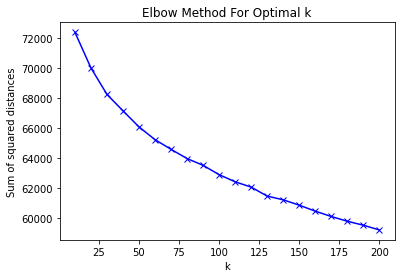

In [588]:
plot_kmeans(K,wvec_ssd,"elbow")

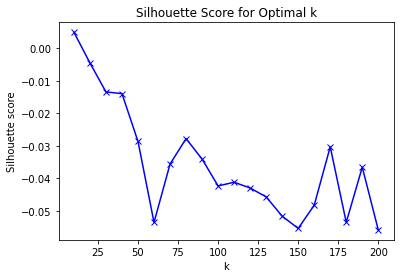

In [589]:
plot_kmeans(K,wvec_silhouette,"silhouette")

Assign labels and centroids to separate variables for later use.

#### 2.5.2 T-SNE + Kmeans

In [61]:
method='barnes_hut'
n_components = 2
verbose = 1

In [62]:
E_tsne = TSNE(n_components=n_components, method=method, verbose=verbose).fit_transform(E)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8401 samples in 0.002s...
[t-SNE] Computed neighbors for 8401 samples in 1.902s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8401
[t-SNE] Computed conditional probabilities for sample 2000 / 8401
[t-SNE] Computed conditional probabilities for sample 3000 / 8401
[t-SNE] Computed conditional probabilities for sample 4000 / 8401
[t-SNE] Computed conditional probabilities for sample 5000 / 8401
[t-SNE] Computed conditional probabilities for sample 6000 / 8401
[t-SNE] Computed conditional probabilities for sample 7000 / 8401
[t-SNE] Computed conditional probabilities for sample 8000 / 8401
[t-SNE] Computed conditional probabilities for sample 8401 / 8401
[t-SNE] Mean sigma: 0.500988
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.830750
[t-SNE] KL divergence after 1000 iterations: 2.455040


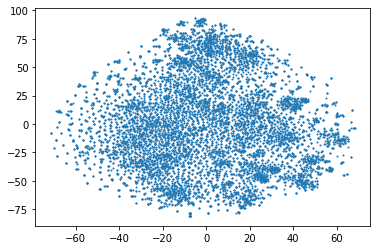

In [63]:
plt.scatter(E_tsne[:, 0], E_tsne[:, 1], s=1);

In [593]:
%%time

tsne_ssd, tsne_silhouette = kmeans_search(E_tsne, K)

For n_clusters = 10 The average silhouette_score is : 0.34488717
For n_clusters = 20 The average silhouette_score is : 0.3372342
For n_clusters = 30 The average silhouette_score is : 0.3312462
For n_clusters = 40 The average silhouette_score is : 0.3336319
For n_clusters = 50 The average silhouette_score is : 0.33292577
For n_clusters = 60 The average silhouette_score is : 0.33240375
For n_clusters = 70 The average silhouette_score is : 0.33114016
For n_clusters = 80 The average silhouette_score is : 0.33670086
For n_clusters = 90 The average silhouette_score is : 0.33434618
For n_clusters = 100 The average silhouette_score is : 0.33501622
For n_clusters = 110 The average silhouette_score is : 0.332212
For n_clusters = 120 The average silhouette_score is : 0.33530146
For n_clusters = 130 The average silhouette_score is : 0.33940127
For n_clusters = 140 The average silhouette_score is : 0.33824897
For n_clusters = 150 The average silhouette_score is : 0.33759972
For n_clusters = 160 The

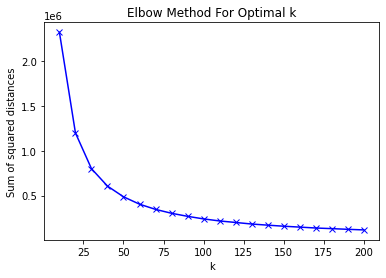

In [594]:
plot_kmeans(K,tsne_ssd,"elbow")

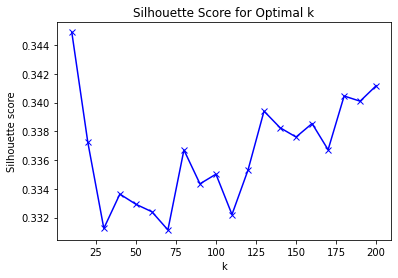

In [595]:
plot_kmeans(K,tsne_silhouette,"silhouette")

#### 2.5.3 PCA + Kmeans

In [64]:
n_components = 0.9
verbose = 1

In [65]:
pca_fit = PCA(n_components = n_components).fit(E)

In [66]:
print(len(pca_fit.explained_variance_ratio_))
print(pca_fit.explained_variance_ratio_)
print(np.sum(pca_fit.explained_variance_ratio_))

193
[0.07628132 0.0345566  0.03028728 0.02639023 0.0245887  0.02212664
 0.02134236 0.01774034 0.0173189  0.01633802 0.01510132 0.01297967
 0.01260761 0.0123261  0.01142174 0.01106987 0.01050173 0.00968806
 0.00927439 0.00897341 0.00877902 0.00864109 0.00825649 0.00794574
 0.0076762  0.00747991 0.00716163 0.00696157 0.00680476 0.00669638
 0.00651169 0.00641438 0.00632268 0.00608887 0.00594684 0.0057728
 0.00562356 0.0055797  0.0054608  0.00540093 0.00530564 0.00510022
 0.0050595  0.00486304 0.00485078 0.00480483 0.00470084 0.00459584
 0.00447069 0.0043073  0.00428018 0.00417935 0.00415495 0.00411507
 0.00398795 0.00397559 0.00386126 0.00384308 0.00380697 0.00375563
 0.00367152 0.00364723 0.00358031 0.0035656  0.00349545 0.00346537
 0.00341881 0.00340772 0.00334292 0.00328467 0.00324471 0.00321177
 0.0031487  0.00313826 0.00307375 0.00304422 0.00300641 0.00298653
 0.00295447 0.00291959 0.00290086 0.00288187 0.00280278 0.0027916
 0.00276687 0.00274055 0.00270718 0.0027036  0.0026616  0.00

In [67]:
E_pca = pca_fit.transform(E)

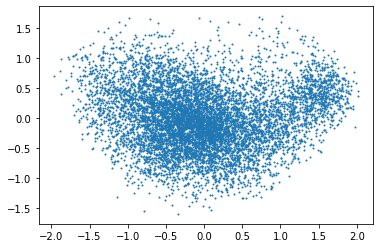

In [68]:
plt.scatter(E_pca[:, 0], E_pca[:, 1], s=1);

In [601]:
%%time

pca_ssd, pca_silhouette = kmeans_search(E_pca, K)

For n_clusters = 10 The average silhouette_score is : 0.012352858
For n_clusters = 20 The average silhouette_score is : 0.0058038337
For n_clusters = 30 The average silhouette_score is : -0.003994512
For n_clusters = 40 The average silhouette_score is : -0.021709612
For n_clusters = 50 The average silhouette_score is : -0.008725485
For n_clusters = 60 The average silhouette_score is : -0.04823015
For n_clusters = 70 The average silhouette_score is : -0.022156313
For n_clusters = 80 The average silhouette_score is : -0.049250927
For n_clusters = 90 The average silhouette_score is : -0.021058626
For n_clusters = 100 The average silhouette_score is : -0.011208477
For n_clusters = 110 The average silhouette_score is : -0.024578236
For n_clusters = 120 The average silhouette_score is : -0.044699457
For n_clusters = 130 The average silhouette_score is : -0.037258327
For n_clusters = 140 The average silhouette_score is : -0.032816883
For n_clusters = 150 The average silhouette_score is : -0.0

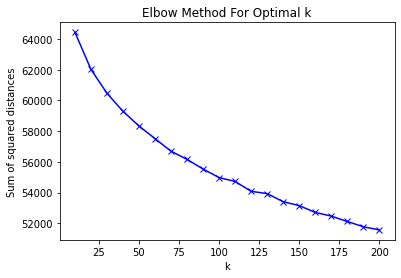

In [602]:
plot_kmeans(K,pca_ssd,"elbow")

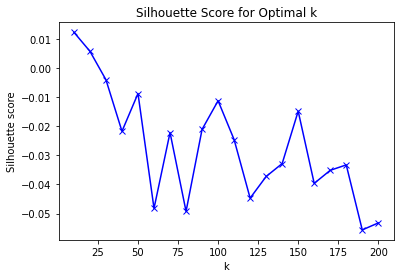

In [603]:
plot_kmeans(K,pca_silhouette,"silhouette")

#### 2.5.4 UMAP + Kmeans

In [69]:
%%time

metric = 'cosine'
dm = cdist(E, E, metric)
np.fill_diagonal(dm, 0)

CPU times: user 24.5 s, sys: 488 ms, total: 25 s
Wall time: 25.4 s


In [70]:
is_valid_dm(dm)

True

In [71]:
mean, std = np.mean(dm), np.std(dm)
print(mean, std)

0.6463656993168528 0.12026897760263146


In [72]:
min_dist=mean - 5*std
n_neighbors = int(0.001*len(E))
n_components=2
print(f"Min distance: {min_dist}")
print(f"N. neighbors: {n_neighbors}")
print(f"N. compontents: {n_components}")

Min distance: 0.04502081130369551
N. neighbors: 8
N. compontents: 2


In [73]:
%%time

E_umap = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
    verbose=verbose
).fit_transform(E)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.04502081130369551,
     n_neighbors=8, random_state=42, verbose=1)
Construct fuzzy simplicial set
Tue Aug  3 18:47:59 2021 Finding Nearest Neighbors
Tue Aug  3 18:47:59 2021 Building RP forest with 10 trees
Tue Aug  3 18:48:01 2021 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Tue Aug  3 18:48:16 2021 Finished Nearest Neighbor Search
Tue Aug  3 18:48:19 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Aug  3 18:48:29 2021 Finished embedding
CPU times: user 27.5 s, sys: 2.19 s, total: 29.7 s
Wall time: 30.2 s


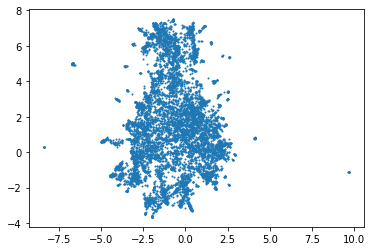

In [74]:
plt.scatter(E_umap[:, 0], E_umap[:, 1], s=1);

In [610]:
%%time

umap_ssd, umap_silhouette = kmeans_search(E_umap, K)

For n_clusters = 10 The average silhouette_score is : 0.34773073
For n_clusters = 20 The average silhouette_score is : 0.33901826
For n_clusters = 30 The average silhouette_score is : 0.33505654
For n_clusters = 40 The average silhouette_score is : 0.33489707
For n_clusters = 50 The average silhouette_score is : 0.33510685
For n_clusters = 60 The average silhouette_score is : 0.3385732
For n_clusters = 70 The average silhouette_score is : 0.33857962
For n_clusters = 80 The average silhouette_score is : 0.34351763
For n_clusters = 90 The average silhouette_score is : 0.34230384
For n_clusters = 100 The average silhouette_score is : 0.33888248
For n_clusters = 110 The average silhouette_score is : 0.34269255
For n_clusters = 120 The average silhouette_score is : 0.33791223
For n_clusters = 130 The average silhouette_score is : 0.3402726
For n_clusters = 140 The average silhouette_score is : 0.34286374
For n_clusters = 150 The average silhouette_score is : 0.34359643
For n_clusters = 160 

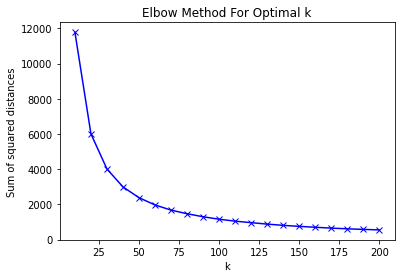

In [611]:
plot_kmeans(K,umap_ssd,"elbow")

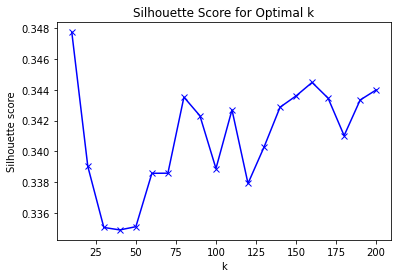

In [612]:
plot_kmeans(K,umap_silhouette,"silhouette")

#### 2.5.5 Choose clustering model

In [75]:
k = 100

In [76]:
%%time

km_base = cluster.KMeans(n_clusters=k,max_iter=300).fit(E)
labels = km_base.labels_
centroids = km_base.cluster_centers_

km_pca = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_pca)
labels_pca = km_pca.labels_

km_umap = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_umap)
labels_umap=km_umap.labels_

km_tsne = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_tsne)
labels_tsne = km_tsne.labels_

CPU times: user 1min 39s, sys: 14.2 s, total: 1min 54s
Wall time: 23.4 s


Create an index that maps each word to a cluster.

In [77]:
word2cluster = {features[idx]: cl for idx, cl in enumerate(labels)}

In [78]:
print(take(10, word2cluster.items()))

[('[', 61), (']', 61), ('aa', 78), ('aa_bowl', 19), ('aardvark_sauce', 56), ('aaron', 77), ('abby', 77), ('ability', 22), ('ability_multitask', 3), ('able', 14)]


Now, conversely, create an index that maps each cluster to a word.

In [79]:
cluster2words = defaultdict(list)
for key, value in word2cluster.items():
    cluster2words[value].append(key)

In [80]:
print(len(cluster2words[0]))
print(cluster2words[0][:100])

3
['gas', 'gas_station', 'pump']


In [81]:
print(len(cluster2words[1]))
print(cluster2words[1][:100])

92
['absolute', 'allllll', 'amazingly', 'angel', 'bam', 'beyond_belief', 'blew_away', 'blew_mind', 'blow_mind', 'bomb', 'chart', 'cloud', 'crazy', 'da_bomb', 'damn', 'darn', 'dayum', 'describe', 'dove', 'dream', 'dreaming', 'entire_life', 'epic', 'ever', 'ever_eaten', 'ever_seen', 'every_single', 'exaggerating', 'exaggeration', 'fell_love', 'flippin', 'freakin', 'freaking', 'genius', 'god', 'hand', 'heart', 'heaven', 'holy_cow', 'honestly', 'icing_cake', 'imagined', 'insanely', 'ive_ever', 'legit', 'legitimately', 'life', 'life_changing', 'literally', 'looooove', 'magic', 'magnificent', 'mama', 'moon', 'mouth', 'must', 'obsessed', 'oh_god', 'oh_goodness', 'oh_gosh', 'oh_man', 'omg', 'otherworldly', 'planet', 'pure', 'secret', 'seriously', 'soo', 'sooo', 'soooo', 'sooooo', 'soooooo', 'soooooooooo', 'super_duper', 'swear', 'teared', 'ultimate', 'unbelievable', 'unbelievably', 'undeniably', 'understatement', 'unicorn', 'unreal', 'utterly', 'wa', 'wanna_slap', 'whoa', 'woah', 'word', 'word

### 2.6 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indeces of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [82]:
pos_nbow[0]

<1x8401 sparse matrix of type '<class 'numpy.float64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [125]:
%%time 

pos_docs, neg_docs = [], []

for idx, doc in enumerate(pos_tok):
    pos_docs.append(Document(doc, pos_nbow[idx], word2idx, E, idx))
    
for idx, doc in enumerate(neg_tok):
    neg_docs.append(Document(doc, neg_nbow[idx], word2idx, E, idx))

CPU times: user 457 ms, sys: 124 ms, total: 581 ms
Wall time: 595 ms


In [126]:
pos_docs[0].nbow

array([[0.00661839, 0.00661839, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [127]:
pos_docs[0].weights_sum

1.0

In [128]:
pos_docs[0].idxs[:10]

[0, 3201, 1, 5255, 7058, 7324, 668, 7710, 6305, 165]

In [129]:
pos_docs[0].vecs[:1][0][:10]

array([ 0.15857954, -0.15556984, -0.0054978 , -0.1308413 , -0.01429296,
       -0.12834749,  0.11757544,  0.13080046,  0.03922231,  0.3269623 ],
      dtype=float32)

### 2.7 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all positive and all negative reviews.

In [205]:
lc_rwmd = LC_RWMD(pos_docs, neg_docs,pos_nbow,neg_nbow,E)

In [206]:
%time lc_rwmd.get_D("cosine")
#%time lc_rwmd.get_L(1)
#%time lc_rwmd.get_rwmd()

CPU times: user 1min 5s, sys: 14.5 s, total: 1min 19s
Wall time: 21.5 s


### 2.8 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [207]:
# Options: 'gale_shapeley','random','full'

pairing = 'gale_shapeley'

In [208]:
%%time

if pairing == 'gale_shapeley':
    print("Running Gale-Shapeley pairing.")
    matcher = Matcher(lc_rwmd.D)
    engaged = matcher.matchmaker()
    matcher.check()
    pairs = [(k, v) for k, v in engaged.items()]
    #pairs = engaged
if pairing == 'random':
    print("Running random pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    shuffle(pos_idx)
    shuffle(neg_idx)
    pairs = zip(pos_idx, neg_idx)
if pairing == 'full':
    print("Running full pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    pairs = [(i,j) for i in pos_idx for j in neg_idx]
    #pos_docs = [d for d in pos_docs for _ in list(range(0,len(neg_docs)))]
    #neg_docs = [d for d in neg_docs for _ in list(range(0,len(pos_docs)))]

Running Gale-Shapeley pairing.
CPU times: user 902 ms, sys: 310 ms, total: 1.21 s
Wall time: 1.67 s


Let's look at the output of Gale-Shapeley:

In [209]:
print(pairs[:20])

[(0, 235), (218, 8), (262, 439), (454, 139), (319, 277), (482, 287), (103, 94), (104, 301), (20, 243), (171, 218), (108, 382), (163, 133), (117, 461), (110, 96), (424, 230), (118, 274), (285, 268), (320, 134), (91, 330), (247, 374)]


In [210]:
example_pairs = [(' '.join(word for word in pos_docs[p[0]].words), 
                  ' '.join(word for word in neg_docs[p[1]].words))
                 for p in pairs]

In [211]:
example_pairs[9][0]

'[ place amazing drink food amazing got rib white curry cauliflower pork_belly pina_colada amazing ]'

In [212]:
example_pairs[9][1]

'[ recommended nextdoor_app plumbing_electrical project hopeful first good customer_service prompt site estimate appointment good aspect ben gave u estimate plumbing bit high replace old sink put new one also attach new water_purification system total looked youtube figured took hour worth plumbing travis estimate electrical professional little research part needed job wanted professional ripoff going charge close part got everything part home_depot come seriously youtube showed completed job hour handyman learning job newly home owner absolutely experience plumbing_electrical carpentry etc open eye company like rip idea ]'

In [213]:
len(pairs)

500

### 2.9 Pairwise WMD with Baseline Kmeans

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm _without_ returning the flow between individual words.

In [214]:
%%time 

wmd_pairs = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word, metric='euclidean')
wmd_pairs.get_distances(thread=False,relax=True)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
CPU times: user 4.4 s, sys: 802 ms, total: 5.2 s
Wall time: 1.41 s


The return value is a matrix of distances between the document pairs.

In [215]:
np.max(wmd_pairs.distances)

3.290803384819796

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm, this time also returning the flow between individual words.

In [226]:
%%time 

wmd_pairs_flow = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word, metric='cosine')
wmd_pairs_flow.get_distances(return_flow = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = False,
                             relax = True)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
CPU times: user 3.98 s, sys: 549 ms, total: 4.52 s
Wall time: 1.5 s


Now we have three return values.

The first one is again a matrix of distances between the document pairs.

In [227]:
np.max(wmd_pairs_flow.distances)

0.5252907640193404

The second return value is a list of tuples with all the words that contributed the most to the distance from the positive documents to the negative ones. These are _not_ sorted from high to low or vice versa.

In [228]:
take(10, wmd_pairs_flow.wc_X1.items())

[('complement', 0.022690050736830655),
 ('shhhhhh', 0.006078577557502461),
 ('mauritious', 0.005085015795348875),
 ('warm_welcoming', 0.021832845681472746),
 ('lit', 0.04140560305106505),
 ('recommended', 0.14401061934162065),
 ('told', 0.01699501116223386),
 ('tomorrow', 0.04573224800026625),
 ('rosie', 0.03716078044531546),
 ('flaming', 0.015990554666271813)]

The third return value is a list of tuples with all the words that contributed the most to the distance from the negative documents to the positive ones. Again, these are _not_ sorted from high to low or vice versa.

In [229]:
take(10, wmd_pairs_flow.wc_X2.items())

[('recommended', 0.04326176237838693),
 ('court', 0.0181839674891758),
 ('hot_pot', 0.06829031833082301),
 ('spinning', 0.013239659791956328),
 ('estimated', 0.018036257182442166),
 ('deal', 0.03610994367523224),
 ('disturbing', 0.03420938469580523),
 ('ccb', 0.0037087363321901324),
 ('titanic', 0.017739174907174513),
 ('realized', 0.02911242918369478)]

In [230]:
take(10, wmd_pairs_flow.cc_X1.items())

[(61, 3.519822335306475),
 (78, 15.760666837579214),
 (19, 2.0070055945689984),
 (56, 11.837945502209088),
 (77, 3.7326566486273958),
 (22, 1.7368636854660717),
 (3, 2.8468845331291006),
 (14, 6.055274111297492),
 (95, 0.659426488619539),
 (52, 1.6364526547857483)]

In [231]:
take(10, wmd_pairs_flow.cc_X2.items())

[(61, 7.7183548069691525),
 (78, 21.611980302100186),
 (19, 0.7716215648553109),
 (56, 3.0916250278161383),
 (77, 1.4848068313490008),
 (22, 1.7395600072694277),
 (3, 3.3322724452745898),
 (14, 8.32641103630232),
 (95, 0.8498532200044182),
 (52, 0.9797292395503984)]

In [232]:
{k: v for k, v in sorted(wmd_pairs_flow.cc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{97: 19.12891712118627,
 78: 15.760666837579214,
 56: 11.837945502209088,
 15: 11.212854847092345,
 84: 9.107839931276633,
 76: 7.11689198699144,
 47: 6.7694702085232175,
 54: 6.208489715617554,
 14: 6.055274111297492,
 87: 3.9730328783546986}

In [233]:
wmd_pairs_flow.get_differences()

### 3.1 Intepreting pairwise WMD flows

Now, let's sort the distances of the words that created the most distance from the positive to the negative reviews.

In [234]:
top_words_x1 = {k: v for k, v in sorted(wmd_pairs_flow.wc_X1_diff.items(), key=lambda item: item[1], reverse=True)[:30]}
top_words_x1_df = pd.DataFrame.from_dict(top_words_x1, orient='index', columns = ["cost"])
top_words_x1_df

,cost
great,1.534928
amazing,1.259641
best,1.037708
delicious,0.994214
love,0.916492
definitely,0.900667
friendly,0.789026
favorite,0.769968
food,0.663806
nice,0.661342


Next, let's see what added most distance when moving from the negative to the positive reviews.

In [235]:
top_words_x2 = {k: v for k, v in sorted(wmd_pairs_flow.wc_X2_diff.items(), key=lambda item: item[1], reverse=True)[:30]}
top_words_x2_df = pd.DataFrame.from_dict(top_words_x2, orient='index', columns = ["cost"])
top_words_x2_df

,cost
never,0.671843
rude,0.667809
order,0.658562
worst,0.608394
customer,0.563309
told,0.534696
minute,0.507275
horrible,0.501564
business,0.464712
employee,0.407162


Finally, let's look at the distances between the two sets by clustering similar words, in order to get a better sense of what kind of "topics" that separate them. Each cluster has a weight that matches the sum of the words belonging to that cluster. We choose *n* top clusters to inspect. To make the clusters interpretable, we also represent each of them by *m* keywords, selected based on the cost they individually add between the two sets.

In [236]:
n_clusters = 10
n_words = 10

In [237]:
c1 = output_clusters(wc=wmd_pairs_flow.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow.cc_X1.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2 = output_clusters(wc=wmd_pairs_flow.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow.cc_X2.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

Positive to negative clusters.

In [238]:
c1

,97,78,56,15,84,76,47,54,14,87
0,great (1.53),house (0.38),delicious (0.99),really (0.26),food (0.66),friendly (0.79),well (0.23),good (0.42),advice (0.16),atmosphere (0.38)
1,amazing (1.26),new (0.27),favorite (0.77),feel (0.19),place (0.44),nice (0.66),different (0.23),little (0.14),work (0.16),beautiful (0.28)
2,best (1.04),back (0.21),fresh (0.5),much (0.16),spot (0.42),staff (0.61),option (0.23),solid (0.11),make_sure (0.13),environment (0.19)
3,love (0.92),looking (0.15),enjoyed (0.45),enough (0.12),try (0.31),super (0.48),also (0.18),worth (0.09),helping (0.12),lovely (0.18)
4,definitely (0.9),first (0.13),loved (0.41),promise (0.11),town (0.29),attentive (0.19),variety (0.17),relatively (0.08),appreciate (0.09),vibe (0.17)
5,highly_recommend (0.63),plan (0.1),perfect (0.38),sure (0.11),dinner (0.23),welcoming (0.17),enjoy (0.15),quantity (0.08),needed (0.06),inviting (0.16)
6,always (0.62),home (0.09),menu (0.21),significant (0.09),restaurant (0.19),everyone (0.17),unique (0.13),quite (0.08),possible (0.05),ambiance (0.15)
7,excellent (0.59),course (0.09),tasty (0.18),worry (0.09),lunch (0.16),accommodating (0.14),wide_variety (0.13),surprised (0.07),consulting (0.04),cute (0.15)
8,everything (0.47),soon (0.09),meal (0.17),totally (0.08),disappoint (0.15),nicest (0.13),plenty (0.11),certainly (0.07),handle (0.04),modern (0.12)
9,awesome (0.41),chance (0.09),mouth_watering (0.16),easily (0.07),dining (0.11),pleasant (0.13),style (0.1),little_pricey (0.06),floater (0.04),cozy (0.12)


Negative to positive clusters.

In [239]:
c2 

,78,15,14,40,61,54,96,36,48,60
0,never (0.67),people (0.36),u (0.34),worst (0.61),say (0.29),overpriced (0.22),told (0.53),order (0.66),rude (0.67),water (0.32)
1,going (0.3),wrong (0.29),talk (0.2),horrible (0.5),please (0.23),disappointed (0.21),said (0.4),minute (0.51),customer (0.56),wet (0.15)
2,get (0.29),could (0.29),done (0.15),terrible (0.4),know (0.22),mediocre (0.18),asked (0.39),hour (0.31),customer_service (0.32),barely (0.14)
3,still (0.25),even (0.28),help (0.15),bad (0.31),tell (0.2),disappointing (0.17),manager (0.36),waiting (0.29),racist (0.14),paper (0.14)
4,another (0.23),leave (0.26),request (0.13),disgusting (0.28),want (0.2),le (0.16),received (0.26),min (0.22),attitude (0.14),large (0.13)
5,one (0.23),way (0.24),take (0.12),awful (0.24),let (0.17),elsewhere (0.15),sent (0.18),waited (0.2),unprofessional (0.12),piece (0.12)
6,closed (0.22),like (0.24),person (0.12),waste_time (0.21),guy (0.16),high (0.13),receive (0.18),slow (0.14),disrespectful (0.12),black (0.11)
7,took (0.2),hope (0.23),would (0.12),avoid (0.21),mean (0.12),stick (0.1),asking (0.15),waited_minute (0.14),act (0.1),oil (0.1)
8,month (0.2),someone (0.22),put (0.11),worse (0.19),joke (0.11),low (0.1),saying (0.13),ready (0.1),treated (0.08),looked (0.08)
9,spent (0.19),anything (0.2),need (0.1),poor (0.17),go (0.11),disappointment (0.08),refused (0.13),line (0.09),acted_like (0.08),bottom (0.08)


In [243]:
x1_costs = pd.DataFrame(wmd_pairs_flow.X1_feat)
x1_costs.index = [p[0] for p in pairs]
x1_costs = x1_costs.sort_index()
x1_costs = x1_costs[c1.columns]
x1_costs['city'] = sample[:1000].city

In [244]:
Counter(x1_costs.city)

Counter({'Atlanta': 250, 'Portland': 250})

In [245]:
x1_costs_long = pd.melt(x1_costs, id_vars=['city']).rename(columns={"variable":"cluster"})
x1_costs_long.head()

,city,cluster,value
0,Atlanta,97,0.012883
1,Portland,97,0.014845
2,Portland,97,0.013307
3,Portland,97,0.014284
4,Portland,97,0.003830


In [246]:
x1_costs_long = x1_costs_long[x1_costs_long.value != 0]

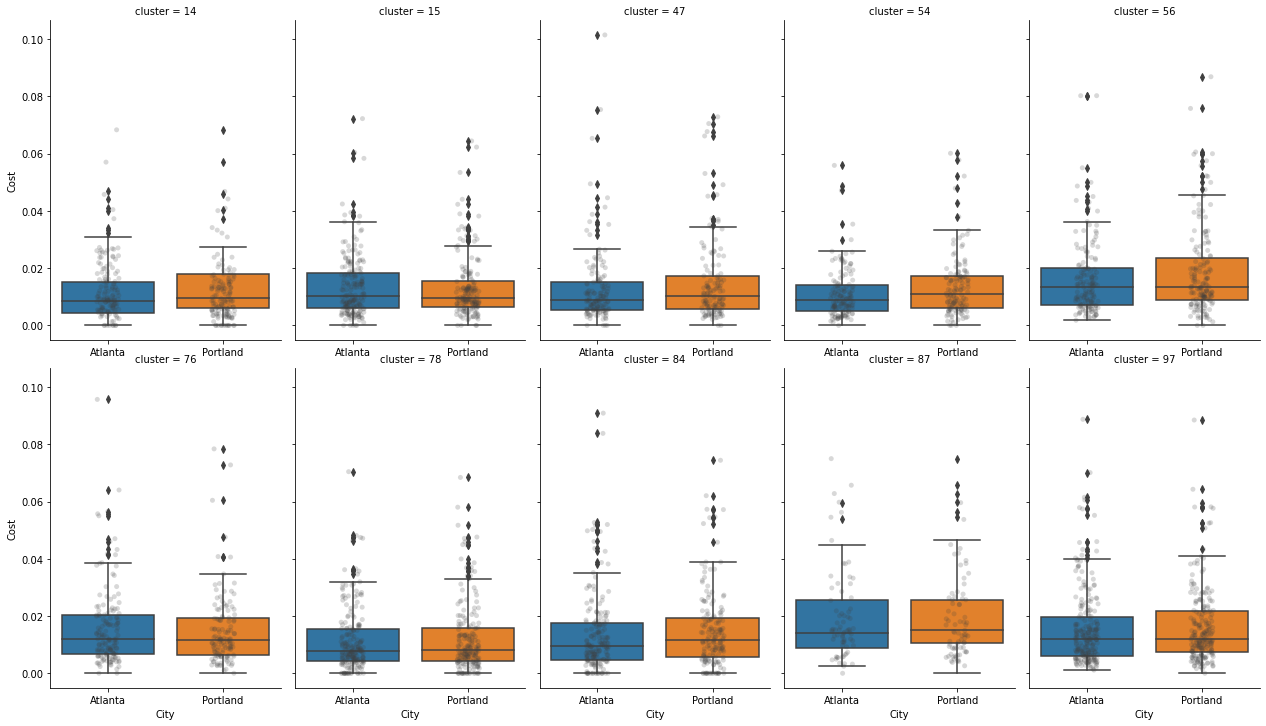

In [247]:
g = sns.catplot(x="city", 
                y="value", 
                col="cluster", 
                data=x1_costs_long, 
                kind="box",
                height=5, 
                aspect=.7,
                col_wrap=5,
                margin_titles=True);
g.map_dataframe(sns.stripplot, 
                x="city", 
                y="value", 
                palette=["#404040"], 
                alpha=0.2, dodge=True)
g.set_axis_labels("City", "Cost")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


In [249]:
x2_costs = pd.DataFrame(wmd_pairs_flow.X1_feat)
x2_costs.index = [p[1] for p in pairs]
x2_costs = x2_costs.sort_index()
x2_costs = x2_costs[c2.columns]
x2_costs['city'] = sample[1000:2000].city.tolist()

ValueError: Length of values (0) does not match length of index (500)

In [924]:
x2_costs_long = pd.melt(x2_costs, id_vars=['city']).rename(columns={"variable":"cluster"})
x2_costs_long.head()

,city,cluster,value
0,Atlanta,5,0.07283
1,Atlanta,5,0.06773
2,Atlanta,5,0.11964
3,Atlanta,5,0.23837
4,Atlanta,5,0.03491


In [925]:
x2_costs_long = x2_costs_long[x2_costs_long.value != 0]

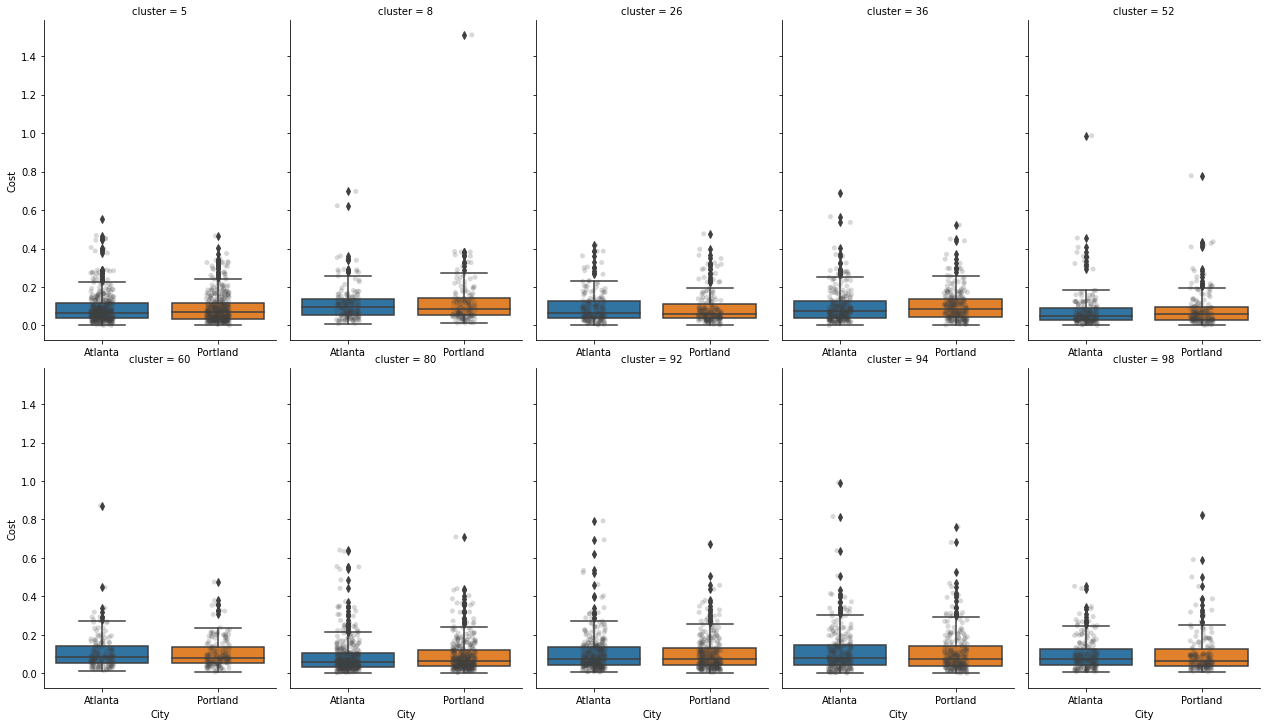

In [926]:
g = sns.catplot(x="city", 
                y="value", 
                col="cluster", 
                data=x2_costs_long, 
                kind="box",
                height=5, 
                aspect=.7,
                col_wrap=5,
                margin_titles=True);
g.map_dataframe(sns.stripplot, 
                x="city", 
                y="value", 
                palette=["#404040"], 
                alpha=0.2, dodge=True)
g.set_axis_labels("City", "Cost")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


## 4 Better clusters with UMAP and T-SNE

#### 4.1 UMAP + Kmeans

In [118]:
word2cluster_u = {features[idx]: cl for idx, cl in enumerate(labels_umap)}

In [119]:
print(take(10, word2cluster_u.items()))

[(']', 84), ('^_', 49), ('`', 4), ('aaargh', 3), ('aaliyah', 8), ('aamir_khan', 54), ('aaron', 13), ('aaron_eckhart', 18), ('ab_tak', 93), ('abandon', 92)]


Now, conversely, create an index that maps each cluster to a word.

In [120]:
cluster2words_u = defaultdict(list)
for key, value in word2cluster_u.items():
    cluster2words_u[value].append(key)

In [121]:
%%time 

wmd_pairs_flow_u = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_u.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 3s, sys: 15.9 s, total: 2min 19s
Wall time: 1min 13s


In [123]:
wmd_pairs_flow_u.get_differences()

In [125]:
c1_u = output_clusters(wc=wmd_pairs_flow_u.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow_u.cc_X1.items(), 
                     c2w=cluster2words_u, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2_u = output_clusters(wc=wmd_pairs_flow_u.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow_u.cc_X2.items(), 
                     c2w=cluster2words_u, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

In [126]:
c1_u

,38,65,48,50,6,45,78,16,14,68
0,great (2.48),loved (1.27),game (1.77),dvd (0.7),still (1.8),year (0.8),film (0.68),little (1.23),performance (1.36),story (0.7)
1,best (2.03),enjoy (0.72),hard (0.42),show (0.4),disney (0.89),new (0.67),although (0.37),entertaining (0.66),role (0.9),quality (0.3)
2,excellent (1.42),well_worth (0.67),cartoon (0.18),hope (0.39),every (0.34),night (0.43),cinema (0.36),hilarious (0.5),star (0.55),quite (0.3)
3,wonderful (1.3),want (0.42),people (0.16),channel (0.37),compared (0.19),day (0.39),hollywood (0.22),comedy (0.43),play (0.46),edge_seat (0.23)
4,song (0.96),check (0.25),segal (0.15),found (0.34),taste (0.19),old (0.38),though (0.18),plus (0.32),playing (0.39),build (0.23)
5,brilliant (0.83),liked (0.23),meatball (0.14),buy (0.33),much (0.16),lived (0.35),throughout (0.17),fulci (0.3),great_job (0.31),clever (0.23)
6,perfect (0.75),enjoyed (0.21),animated (0.14),glad (0.31),one (0.15),late (0.33),filled (0.17),humor (0.28),hamlet (0.2),bit (0.23)
7,beautiful (0.68),would_recommend (0.19),subtitle (0.14),film_festival (0.27),sf (0.14),memory (0.29),pure (0.14),martial_art (0.26),davy (0.19),romantic_comedy (0.22)
8,soundtrack (0.67),seen (0.17),serial (0.13),first_saw (0.25),eighty (0.14),grew (0.25),part (0.12),enjoyable (0.23),rest_cast (0.18),extremely (0.19)
9,amazing (0.65),thought (0.17),exactly (0.13),video (0.25),perhaps (0.13),last (0.25),dated (0.11),humour (0.21),supporting_cast (0.18),suspenseful (0.13)


In [127]:
c2_u

,65,48,56,6,30,16,63,50,78,77
0,movie (2.33),would (0.5),bad (5.31),even (1.48),worst (2.48),stupid (1.61),better (1.0),came (0.35),director (0.41),supposed (0.74)
1,really (0.94),reason (0.47),plot (1.52),could (1.22),ever_seen (0.95),funny (0.87),least (0.77),fox (0.31),effort (0.34),case (0.52)
2,rating (0.84),going (0.46),boring (1.38),instead (1.03),one_worst (0.88),joke (0.76),nothing (0.76),sat (0.31),seems (0.27),making (0.43)
3,say (0.72),gave (0.42),awful (1.34),made (0.83),ever (0.74),idiotic (0.39),ok (0.63),episode (0.31),numerous (0.27),understand (0.39)
4,rent (0.7),basically (0.42),terrible (1.24),enough (0.72),hour (0.74),unrealistic (0.37),cheap (0.6),finished (0.28),point (0.27),obviously (0.36)
5,maybe (0.61),never (0.4),poor (1.12),idea (0.59),minute (0.72),lot (0.37),anything (0.56),picked (0.27),contain (0.19),project (0.27)
6,anyone (0.61),wrong (0.4),horrible (0.93),either (0.46),worse (0.72),overall (0.32),sequel (0.43),series (0.25),example (0.18),sort (0.26)
7,watching (0.52),happen (0.39),script (0.7),rest (0.45),something (0.68),nudity (0.29),whole_thing (0.42),blockbuster (0.25),almost (0.15),fact (0.26)
8,review (0.52),tried (0.37),dialog (0.63),make_sense (0.45),waste (0.65),serious (0.28),b (0.41),rented (0.21),shocking (0.15),blame (0.25)
9,recommend (0.48),like (0.37),dull (0.6),producer (0.36),waste_time (0.61),disgusting (0.28),expect (0.39),went_see (0.21),columbo (0.14),confused (0.25)


#### 4.1 T-SNE + Kmeans

In [128]:
word2cluster_t = {features[idx]: cl for idx, cl in enumerate(labels_tsne)}

In [129]:
print(take(10, word2cluster_t.items()))

[(']', 65), ('^_', 25), ('`', 45), ('aaargh', 79), ('aaliyah', 39), ('aamir_khan', 56), ('aaron', 84), ('aaron_eckhart', 20), ('ab_tak', 54), ('abandon', 74)]


Now, conversely, create an index that maps each cluster to a word.

In [139]:
cluster2words_t = defaultdict(list)
for key, value in word2cluster_t.items():
    cluster2words_t[value].append(key)

In [141]:
%%time 

wmd_pairs_flow_t = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_t.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_t, 
                               c2w = cluster2words_t,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 5s, sys: 14.9 s, total: 2min 20s
Wall time: 1min 16s


In [142]:
wmd_pairs_flow_t.get_differences()

In [143]:
c1_t = output_clusters(wc=wmd_pairs_flow_t.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow_t.cc_X1.items(), 
                     c2w=cluster2words_t, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2_t = output_clusters(wc=wmd_pairs_flow_t.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow_t.cc_X2.items(), 
                     c2w=cluster2words_t, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

In [144]:
c1_t

,92,67,86,48,99,87,10,31,17,95
0,loved (1.27),great (2.48),disney (0.89),thought (0.17),game (1.77),performance (1.36),dvd (0.7),real (0.65),feeling (0.6),year (0.8)
1,time (0.84),excellent (1.42),film (0.68),people (0.16),hilarious (0.5),role (0.9),hope (0.39),often (0.4),feel (0.54),night (0.43)
2,well_worth (0.67),wonderful (1.3),entertaining (0.66),exactly (0.13),comedy (0.43),star (0.55),channel (0.37),moving (0.35),message (0.43),day (0.39)
3,fan (0.55),song (0.96),definitely (0.54),folk (0.12),scifi (0.43),play (0.46),found (0.34),filmed (0.21),reality (0.34),lived (0.35)
4,wish (0.28),brilliant (0.83),special (0.39),shocked (0.11),show (0.4),playing (0.39),buy (0.33),top (0.17),theme (0.3),memory (0.29)
5,liked (0.23),perfect (0.75),cinema (0.36),happy_ending (0.11),humor (0.28),great_job (0.31),glad (0.31),main (0.15),issue (0.21),future (0.26)
6,enjoyed (0.21),beautiful (0.68),particularly (0.35),wanting (0.09),short (0.24),usual (0.25),film_festival (0.27),character (0.15),society (0.18),grew (0.25)
7,seen (0.17),soundtrack (0.67),classic (0.33),figured (0.08),clever (0.23),rest_cast (0.18),first_saw (0.25),segment (0.13),importance (0.17),last (0.25)
8,buy_copy (0.16),amazing (0.65),work (0.33),running_time (0.08),humour (0.21),supporting_cast (0.18),video (0.25),sequence (0.13),complex (0.16),took (0.22)
9,really_liked (0.16),incredible (0.59),highly_recommend (0.28),cared (0.08),one_liner (0.17),shine (0.17),theater (0.21),edited (0.11),dealing (0.16),weekend (0.21)


In [145]:
c2_t

,28,92,48,89,49,19,31,42,82,86
0,bad (5.31),movie (2.33),hour (0.74),worst (2.48),even (1.48),really (0.94),shot (0.67),could (1.22),made (0.83),better (1.0)
1,stupid (1.61),rating (0.84),minute (0.72),ever_seen (0.95),enough (0.72),maybe (0.61),scene (0.54),instead (1.03),supposed (0.74),original (0.33)
2,plot (1.52),say (0.72),anyone (0.61),one_worst (0.88),idea (0.59),mean (0.42),camera (0.51),least (0.77),making (0.43),overall (0.32)
3,boring (1.38),watching (0.52),bored (0.58),ever (0.74),premise (0.45),guess (0.38),numerous (0.27),nothing (0.76),wrong (0.4),serious (0.28)
4,awful (1.34),review (0.52),end (0.5),rent (0.7),disappointing (0.36),like (0.37),main_character (0.27),anything (0.56),line (0.27),produced (0.14)
5,terrible (1.24),reason (0.47),depressing (0.49),something (0.68),producer (0.36),someone (0.35),echo (0.19),either (0.46),meant (0.17),standard (0.08)
6,poor (1.12),disappointed (0.34),actually (0.47),waste (0.65),unfortunately (0.35),seriously (0.32),example (0.18),gave (0.42),looking (0.17),bollywood (0.08)
7,horrible (0.93),comment (0.34),going (0.46),waste_time (0.61),stereotype (0.29),anymore (0.26),relentlessly (0.17),laugh (0.34),ruin (0.15),worked (0.07)
8,worse (0.72),saying (0.33),make_sense (0.45),ever_made (0.56),seems (0.27),hate (0.24),clip (0.16),cool (0.32),appeal (0.13),equally (0.07)
9,dialog (0.63),hated (0.32),seemed (0.45),recommend (0.48),project (0.27),hell (0.24),particular (0.16),seagal (0.29),describe (0.12),dubbed (0.07)


## 5 Reduced Dimension Inputs

### 5.1 UMAP

In [ ]:
### TODO: lcwmd with UMAP

In [170]:
%%time 

wmd_pairs_flow_uvecs = WMDPairs(pos_docs,neg_docs,pairs,E_umap,idx2word)
wmd_pairs_flow_uvecs.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 1min 34s, sys: 4.71 s, total: 1min 39s
Wall time: 1min 30s


### 5.2 T-SNE

## 6 Statistical Models

In [234]:
import statsmodels.api as sm

In [317]:
np.max(wmd_pairs_flow.X1_feat)

0.39088

In [276]:
feats = np.copy(wmd_pairs_flow.X1_feat)

In [277]:
feats[feats>0] = 1
feats

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [258]:
np.sum(feats[0,])

39.0

In [279]:
ols = sm.OLS(np.sum(wmd_pairs_flow.X1_feat, axis=1), feats)
res = ols.fit()

In [289]:
params = list(np.round(res.params, 3))

In [309]:
params.index(sorted(params)[-97])

15

In [311]:
params[97]

0.003

In [318]:
print(cluster2words[97])

['addressed', 'allowed', 'apparent', 'avoids', 'breakdown', 'carefully', 'central', 'central_character', 'change', 'changing', 'choosing', 'chosen', 'claustrophobia', 'clear', 'close', 'closest', 'coincidence', 'comedy_tragedy', 'common', 'complicated', 'concentrate', 'concerned', 'concerning', 'conflict', 'connect', 'connected', 'connecting', 'connection', 'consequently', 'construct', 'contempt', 'continuing', 'conviction', 'dealt', 'despicable', 'despite_fact', 'detached', 'develop', 'developed', 'developing', 'development', 'develops', 'device', 'dignity', 'disparate', 'dominate', 'dramatically', 'drawn', 'eliminated', 'encountered', 'establish', 'established', 'establishing', 'event', 'event_unfold', 'evolve', 'evolves', 'explicitly', 'explored', 'fall_apart', 'feel_sympathy', 'fictional', 'focus', 'focused', 'focusing', 'follow', 'following', 'form', 'forward', 'foundation', 'framework', 'gap', 'general', 'glimpse', 'gradual', 'hint', 'hinted', 'hopeless', 'identified', 'ignoring'

## Appendix: Many-to-many WMD

This was a first attempt to do the flows from words between many documents, without first filtering using Gale-Shapeley. However, this proved too inefficient. As you can see looking at the CPU times, it is very slow even with extremely small samples and the time complexity is quadratic (or worse?), meaning it rapidly gets even worse as the sample size increases.

In [155]:
%time m2m_distances = WMDManyToMany(pos_docs[:20], neg_docs[:20],E,idx2word).get_distances(return_flow = False)

CPU times: user 1min 48s, sys: 12.7 s, total: 2min 1s
Wall time: 50 s


In [156]:
%time m2m_distances_flow, wc_X1, wc_X2 = WMDManyToMany(pos_docs[:20],neg_docs[:20],E,idx2word).get_distances(return_flow = True)

CPU times: user 1min 52s, sys: 13.5 s, total: 2min 5s
Wall time: 51.4 s


In [157]:
{k: v for k, v in sorted(wc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{'karen': 8.69223,
 'wrenching': 8.31882,
 'carpenter': 7.468960000000001,
 'laughter': 7.467879999999999,
 'liked': 6.864090000000003,
 'mom': 6.791519999999999,
 'gut': 6.759419999999999,
 'love': 6.551409999999997,
 'camp': 6.533080000000001,
 'hr': 6.1393699999999995}

In [158]:
{k: v for k, v in sorted(wc_X2.items(), key=lambda item: item[1], reverse=True)[:10]}

{'hopper': 8.372459999999998,
 'jake': 7.63837,
 'movie': 7.267059999999995,
 'film': 6.936379999999998,
 'shakespeare': 5.99276,
 'oddness': 5.53033,
 'terrible': 4.943440000000001,
 'parent': 4.751790000000001,
 'actor': 4.672620000000001,
 'bad': 4.430020000000002}